# Text Classification
> ## Sentiment Analysis of IMDB Movie Reviews

<br>
Hosein Mohebbi<br>

<small>hosein_mohebbi@comp.iust.ac.ir</small><br>
<small>hosein.mohebbi75@gmail.com</small>


# Project Overview

>The main aim of this project is evaluate some base classifiers in sentiment analysis task. To tackle this problem has been tried any possible combination of four word embedding approaches (BOW, TF-IDF, Word2Vec, BERT) and four base classifiers (SVM, Naive Bayes, Decision Tree, Random Forest) as well as some text pre-processing techniques on the IMDB movie reviews dataset.
Besides, in the end, it is attempted to solve this problem by combining of BERT Embedding and two deep neural network architectures.

> IMDB movie reviews dataset Dataset contains 50K reviews, half of which are positive and the other half negative. This dataset was compiled by <a href="http://ai.stanford.edu/~amaas/">Andrew Maas</a> and can be find here: <a href="http://ai.stanford.edu/~amaas/data/sentiment/">Large Movie Review Dataset</a>



# Downloading & Installing Prerequisites

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-11-30 11:12:17--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.4MB/s    in 6.7s    

2019-11-30 11:12:24 (12.0 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!tar -zxvf aclImdb_v1.tar.gz > /dev/null

In [0]:
!pip3 install bert-embedding

In [0]:
!pip3 install mxnet-cu100

In [0]:
!pip3 install sentence-transformers

In [0]:
!ls

aclImdb  aclImdb_v1.tar.gz  sample_data


# Required Packages

In [4]:
import os
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tag import pos_tag
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import mxnet as mx
from bert_embedding import BertEmbedding
from sentence_transformers import SentenceTransformer
import gensim 
from gensim.models import Word2Vec 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading DataSet


> Dataset has been divided evenly into a training set and a test set. Moreover, each set contains 12.5K positive and 12.5K negative reviews. The training and test data were loaded as a Pandas data frames.



In [0]:
def loadDataset(data_dir):
    
    data = {}
    for partition in ["train", "test"]:
        data[partition] = []
        for sentiment in ["neg", "pos"]:
            lable = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, partition, sentiment)
            files = os.listdir(path)
            for f_name in files:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[partition].append([review, lable])

    random.seed(4) # to comparision purpose
    random.shuffle(data["train"])
    random.shuffle(data["test"])
    
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [0]:
data_dir = "aclImdb/"
train_data, test_data = loadDataset(data_dir)

Here are the first 5 rows of the training data:

In [0]:
# Debugging
train_data.head()

,text,sentiment
0,"Simply awful slasher, molded from the I KNOW W...",0
1,I was looking forward to seeing John Carpenter...,0
2,Six Degrees is a wonderful show! I watched the...,1
3,"So terrific, so good. I have never seen a man ...",1
4,Good show.<br /><br />The basic background is ...,1


# Cleaning Dataset
> Since this dataset scraped from the web, some HTML codes got mixed up with it. So, cleaning up these texts by removing HTML tags is required. Removing numbers, punctuations, and stop words, replacing negative contraction verb with whose complete forms like won't, splitting compound nouns that are made with hyphen like state-of-the-art (EXCEPT BERT), and normalizing texts by lowering them would be beneficial.

> To remove stop words, the NLTK stop words set have been used. But, some words which have a negative meaning, such as not or nor, have been removed from the set and some contraction patterns like 're or 'm have been added to stop words set. This custom Stop Word was applied for Word2Vec vectorization.

> Due to BERT embedding was trained on Wikipedia data, for this case we allow numbers and some of the punctuations like [, / () : ; '] and compound nouns that are made with hyphen which may cause a more reliable embedding to remain in the text. Moreover, we save !,?, and . to detect the end of the sentence for a later purpose (generate BERT according to each sentence).

> Stemming and lemmatization according to POS tags of words are used for BOW and TF-IDF embeddings.

> Finally, we have replaced white spaces with only one space.


In [0]:
def NormalizeWithPOS(text):
    # Lemmatization & Stemming according to POS tagging

    word_list = word_tokenize(text)
    rev = []
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer() 
    for word, tag in pos_tag(word_list):
        if tag.startswith('J'):
            w = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemmatizer.lemmatize(word, pos='r')
        else:
            w = word
        w = stemmer.stem(w)
        rev.append(w)
    review = ' '.join(rev)
    return review

In [0]:
def cleanText(text):
    
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)

    if embedding is not 'BERT':
        text = re.sub(r"[0-9]+", ' ', text)
        text = re.sub(r"-", ' ', text)
    
    
    text = text.strip().lower()
    
    if embedding is 'WORD2VEC_NO_STOP':
        # Remove Stop words
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
        stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                               'would','must',"'ve","'ll",'may'})
    
        word_list = word_tokenize(text)
        filtered_list = [w for w in word_list if not w in stop_words]
        text = ' '.join(filtered_list)
    
    if embedding is not 'BERT':
        # Remove other contractions
        text = re.sub(r"'", ' ', text)
    
    # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of the sentence detection [,/():;']
        filters='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\?+', '?', text)
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    if embedding is 'BERT':
        text = re.sub(r'\( *\)', ' ', text)

    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)
    
    text = ''.join(text)

    return text

### Adding cleaned reviews as a column in our data frame.

> As mentioned before, we distinguish between embedding approaches in data cleaning. So we added 'clean_text', 'clean_text_normalized', 'clean_text_w2v_no_stop', 'clean_text_bert' columns in our data frame that each column is a cleaned data and prepared for a specific word embedding.

In [0]:
embedding = ''
# for Word2Vec with stop words
train_data['clean_text'] = train_data['text'].apply(cleanText)
test_data['clean_text'] = test_data['text'].apply(cleanText)

In [0]:
# for BOW and TFIDF(s)
train_data['clean_text_normalized'] = train_data['clean_text'].apply(NormalizeWithPOS)
test_data['clean_text_normalized'] = test_data['clean_text'].apply(NormalizeWithPOS)

### Low Frequency Words of Train Data - just for BOW & TFIDF

> Find words that have been repeated less than 5 times in the entire dataset.

In [0]:
freq_train = pd.Series(' '.join(train_data['clean_text_normalized']).split()).value_counts()
less_five_freq_train = freq_train[(freq_train <5)]
print(less_five_freq_train)

azadi       4
wynorski    4
järegård    4
tacit       4
xtian       4
           ..
stubbl      1
santosh     1
keyser      1
mada        1
kristan     1
Length: 30510, dtype: int64


### Low Frequency Words of Test Data - just for BOW & TFIDF

In [0]:
freq_test = pd.Series(' '.join(test_data['clean_text_normalized']).split()).value_counts()
less_five_freq_test = freq_test[(freq_test <5)]
print(less_five_freq_test)

begrudgingli         4
akiko                4
cogniz               4
piovani              4
bw                   4
                    ..
hamel                1
cochran´             1
depopul              1
nichev               1
thelittlesongbird    1
Length: 29987, dtype: int64


### Remove words with frequency less than 5  - just for BOW & TFIDF

> This effectively decreases the dimensions of BOW and TF-IDF vectors.

In [0]:
train_data['clean_text_normalized'] = train_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
test_data['clean_text_normalized'] = test_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_test))

### Continue to add cleaned reviews as a column in our data frame:

In [0]:
embedding = 'WORD2VEC_NO_STOP'
# for Word2Vec without stop words
train_data['clean_text_w2v_no_stop'] = train_data['text'].apply(cleanText)
test_data['clean_text_w2v_no_stop'] = test_data['text'].apply(cleanText)

In [0]:
embedding = 'BERT'
# for BERT(s)
train_data['clean_text_bert'] = train_data['text'].apply(cleanText)
test_data['clean_text_bert'] = test_data['text'].apply(cleanText)

### A visual comparison of different cleaned data

In [0]:
# Debugging
print("A review example of dataset before cleaning:", end="\n\n")
print(train_data.iloc[3]['text'], end='\n\n')

print("clean_text:")
print(train_data.iloc[3]['clean_text'], end="\n\n")

print("clean_text_normalized:")
print(train_data.iloc[3]['clean_text_normalized'], end="\n\n")

print("clean_text_w2v_no_stop:")
print(train_data.iloc[3]['clean_text_w2v_no_stop'], end="\n\n")

print("clean_text_bert:")
print(train_data.iloc[3]['clean_text_bert'], end="\n\n")

A review example of dataset before cleaning:

I first discovered Alexander Korda's (1940) Fantasy, THE THIEF OF BAGDAD in the early 1950's on a re-issue billed as "The Wonder Show of the Century!" Both Korda Technicolor films, THE THIEF OF BAGDAD and JUNGLE BOOK were shown on one never to be forgotten program. The music of Miklos Rozsa enhanced both films. The Technicolor in each was incredibly beautiful! THE THIEF OF BAGDAD has remained on my list as the best fantasy film ever made. As the years passed, it became more difficult to enjoy the film's color in the way it had originally been presented in. True Technicolor gave way to a Eastman Color process in the middle 1950's. Both Kino and Samuel Goldwyn reissued the film both theatrically and on video. But the Eastman Color prints were more pastel in nature and muted the vibrancy of the original Technicolor. The Laser Disc release of this title also has the pastel look to it -- nice, but not as it should be. NOW comes the M-G-M DVD (3 

# Vectorization

> To introduce our data to our classifiers except for Decision Tree, we need to convert each review to numeric features: this is vectorization.

<b>Bag Of Words (BOW):</b>
>  In this approach, we make a list of all the unique words in training data called the vocabulary. then, given an input text, we create a fixed numerical vector that counts each word of the vocabulary.

> To use BOW vectorization in Python, we can use the CountVectorizer function from the scikit-learn library. We pass NLTK stop words and our custom clean text function to remove useless words of training data thereby reducing the size of the BOW vectors until 19368.

<b>TFIDF:</b>
> The tf–idf is the product of two statistics, term frequency and inverse document frequency.

> $W_{x,y} = tf_{x,y} \times \log(\frac{N}{df_x})$

> $tf_{x,y} =$ frequency of x in y

> $df_x =$ number of documents containing x

> $N =$ total number of documents


> Despite the simplicity and low time complexity, BOW and TF-IDF have two major drawbacks. First, as the size of the data and the number of unique words in the training text increases, their length of vectors becomes much larger. Moreover, in these two approaches, only words and their repetitions are important and the order of the words in the text will not be considered in the model.
Hence, we have considered both Word2Vec and BERT embedding approaches to our experiments.


<b>Word2Vec</b>
>  Word2Vec consists of two models which are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures: Continuous Bag of Words and Skip Gram.
The basic idea of Word2Vec is words that occur in similar context tend to be closer to each other in vector space. <a href="https://pypi.org/project/gensim/">gensim</a> library is used to generate word vectors in Python.

<a href="https://arxiv.org/abs/1810.04805">BERT</a> <b>(Bidirectional Encoder Representations  from Transformers):</b>
> BERT, published by Google, is pre-trained language model word representation which transforms each word into a vector with a fixed size of 768.</br>

> In this project, we used BERT embedding twice and report their results independently. once, we tokenized each training data into words, then compute BERT embedding of each word, and finally, mean all the BERT vectors of the words as a review representation.
In a second way, we tokenized each training data into sentences and computed the mean of BERT embedding of the sentences to present each training data.

> To utilize BERT embedding  for two mentioned purposes, we have used these two libraries respectively: </br>
<a href= "https://pypi.org/project/bert-embedding/">bert-embedding 1.0.1</a> </br>
<a href= "https://github.com/UKPLab/sentence-transformers">Sentence Transformers</a>

In [0]:
def mean(z): # used for BERT (word version) and Word2Vec
    return sum(itertools.chain(z))/len(z)

#BOW

In [0]:
embedding = 'BOW'
vectorizer = CountVectorizer(stop_words='english')

bow_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
bow_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(bow_training_features.shape)

(25000, 19368)


# TF-IDF

> With Stop Words



In [0]:
embedding = 'TFIDF_WITH_STOP'
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)

tfidf_with_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_with_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_with_stop_training_features.shape)

(25000, 20000)


# TF-IDF

> Without Stop Words



In [0]:
embedding = 'TFIDF_NO_STOP'
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000)

tfidf_no_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_no_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_no_stop_training_features.shape)

(25000, 20000)


# WORD2VEC

> In this experiment, we use two types of data to construct word2vec vectors. once, normal data and data by removing their stop words.

> For the test data, first, we check that the word already exists in the vocabulary. Otherwise, we skip that word. 
Finally, we use mean operator overall word vectors that are also of fixed length and use just a vector to represent the review.

In [0]:
def embeddToWord2Vec(text):
    words = word_tokenize(text)
    
    if embedding is 'WORD2VEC_WITH_STOP':
        result = [w2v_with_stop_model.wv[w] for w in words if w in w2v_with_stop_model.wv.vocab]
    else:
        result = [w2v_no_stop_model.wv[w] for w in words if w in w2v_no_stop_model.wv.vocab]
    
    feature = [mean(x) for x in zip(*result)]
    return feature

In [0]:
def wordTokenize(text):
  return word_tokenize(text)

### Word2Vec

> With Stop Words



In [0]:
embedding = 'WORD2VEC_WITH_STOP'

In [0]:
words = train_data['clean_text'].apply(wordTokenize)
w2v_with_stop_model = gensim.models.Word2Vec(words, min_count = 2, size = 100, window = 5) 

In [0]:
word2vec_with_stop_training_features = train_data['clean_text'].apply(embeddToWord2Vec)
word2vec_with_stop_test_features = test_data['clean_text'].apply(embeddToWord2Vec)

In [0]:
feature = [x for x in word2vec_with_stop_training_features.transpose()]
word2vec_with_stop_training_features = np.asarray(feature)

feature = [x for x in word2vec_with_stop_test_features.transpose()]
word2vec_with_stop_test_features = np.asarray(feature)

print(word2vec_with_stop_training_features.shape)

(25000, 100)


### Word2Vec

> Without Stop Words



In [0]:
embedding = 'WORD2VEC_NO_STOP'

In [0]:
words = train_data['clean_text_w2v_no_stop'].apply(wordTokenize)
w2v_no_stop_model = gensim.models.Word2Vec(words, min_count = 2, size = 100, window = 5) 

In [0]:
word2vec_no_stop_training_features = train_data['clean_text_w2v_no_stop'].apply(embeddToWord2Vec)
word2vec_no_stop_test_features = test_data['clean_text_w2v_no_stop'].apply(embeddToWord2Vec)

In [0]:
feature = [x for x in word2vec_no_stop_training_features.transpose()]
word2vec_no_stop_training_features = np.asarray(feature)

feature = [x for x in word2vec_no_stop_test_features.transpose()]
word2vec_no_stop_test_features = np.asarray(feature)

print(word2vec_no_stop_training_features.shape)

(25000, 100)


# BERT

As we mentioned before, we used BERT embedding twice and report their results independently. once, we tokenized each training data into words, then compute BERT embedding of each word, and finally, mean all the BERT vectors of the words as a review representation. In a second way, we tokenized each training data into sentences and computed the mean of BERT embedding of the sentences to present each training data.

In [0]:
# Cleaning before BERT
embedding = 'BERT'

### (BERT)
> Word Tokenization Version



In [0]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg') # avg is refer to handle OOV
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [mean(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [mean(x) for x in zip(*result)]
  
    return feature

To take advantage of GPU:

In [0]:
ctx = mx.gpu(0)
bert = BertEmbedding(ctx=ctx)

In [0]:
bert_version = 'WORD'
bert_word_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_word_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [0]:
feature = [x for x in bert_word_training_features.transpose()]
bert_word_training_features = np.asarray(feature)

feature = [x for x in bert_word_test_features.transpose()]
bert_word_test_features = np.asarray(feature)

print(bert_word_training_features.shape)

(25000, 768)


### (BERT) 
> Sentence Tokenization Version



In [0]:
bert_transformers = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:23<00:00, 17.1MB/s]


In [0]:
bert_version = 'SENTENCE'
bert_sentence_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_sentence_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [0]:
feature = [x for x in bert_sentence_training_features.transpose()]
bert_sentence_training_features = np.asarray(feature)

feature = [x for x in bert_sentence_test_features.transpose()]
bert_sentence_test_features = np.asarray(feature)

print(bert_sentence_training_features.shape)

(25000, 768)


# Classifiers

# Model & Training & Evaluation & Result

> For each classifier, we have calculated and print accuracy, confusion matrix, precision, recall, and f1-score metrics. we have also plot ROC curve. To compute False Positive and True Positive of a class, we used roc_curve function in the Scikit Learn library. This function get labels and target scores as input parameters. Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions. So in order to calculate the target score we used decision_function for SVM classifier and predict_proba for others.

In [0]:
# A function to plot and print result
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_data["sentiment"], y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_data["sentiment"],y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_data["sentiment"],y_pred))

    # Plot
    fpr, tpr, thresholds = roc_curve(test_data["sentiment"], y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

# SVM

In [0]:
model = SVC(kernel ='linear', C = 1)

> BOW Features

In [0]:
# Training 
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_svm = model.predict(bow_test_features)
y_prob_bow_svm = model.decision_function(bow_test_features)

Accuracy: 81.94

Confusion Matrix:
 [[10428  2072]
 [ 2444 10056]]
              precision    recall  f1-score   support

          -1       0.81      0.83      0.82     12500
           1       0.83      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.889747


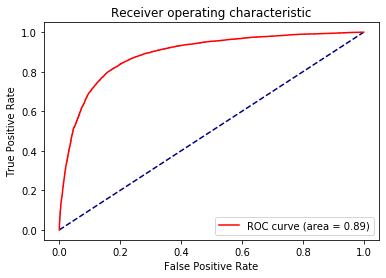

In [0]:
# Result
printResult(y_pred_bow_svm, y_prob_bow_svm)

> TFIDF with Stop Words Features

In [0]:
# Training 
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_svm = model.predict(tfidf_with_stop_test_features)
y_prob_tfidf_with_stop_svm = model.decision_function(tfidf_with_stop_test_features)

Accuracy: 89.59

Confusion Matrix:
 [[11199  1301]
 [ 1301 11199]]
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90     12500
           1       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Area under the ROC curve : 0.961654


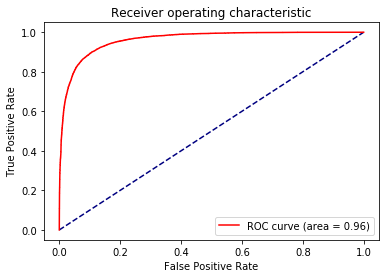

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_svm, y_prob_tfidf_with_stop_svm)

> TFIDF without Stop Words Features

In [0]:
# Training 
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_svm = model.predict(tfidf_no_stop_test_features)
y_prob_tfidf_no_stop_svm = model.decision_function(tfidf_no_stop_test_features)

Accuracy: 87.93

Confusion Matrix:
 [[11039  1461]
 [ 1556 10944]]
              precision    recall  f1-score   support

          -1       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Area under the ROC curve : 0.949651


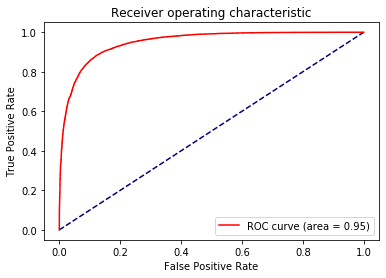

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_svm, y_prob_tfidf_no_stop_svm)

> Word2Vec with Stop Words Features

In [0]:
# Training 
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_svm = model.predict(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_svm = model.decision_function(word2vec_with_stop_test_features)

Accuracy: 83.85

Confusion Matrix:
 [[10466  2034]
 [ 2004 10496]]
              precision    recall  f1-score   support

          -1       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.916006


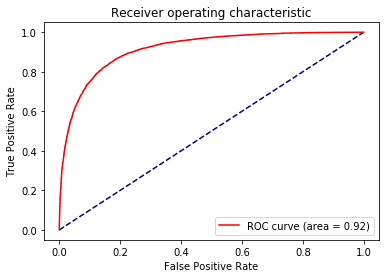

In [0]:
# Result
printResult(y_pred_w2v_with_stop_svm, y_prob_w2v_with_stop_svm)

> Word2Vec without Stop Words Features

In [0]:
# Training 
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_svm = model.predict(word2vec_no_stop_test_features)
y_prob_w2v_no_stop_svm = model.decision_function(word2vec_no_stop_test_features)

Accuracy: 84.34

Confusion Matrix:
 [[10561  1939]
 [ 1977 10523]]
              precision    recall  f1-score   support

          -1       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.918571


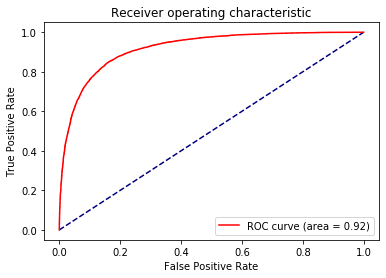

In [0]:
# Result
printResult(y_pred_w2v_no_stop_svm, y_prob_w2v_no_stop_svm)

> BERT Word Version Features

In [0]:
# Training 
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_svm = model.predict(bert_word_test_features)
y_prob_bert_words_svm = model.decision_function(bert_word_test_features)

Accuracy: 87.46

Confusion Matrix:
 [[10948  1552]
 [ 1584 10916]]
              precision    recall  f1-score   support

          -1       0.87      0.88      0.87     12500
           1       0.88      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Area under the ROC curve : 0.944653


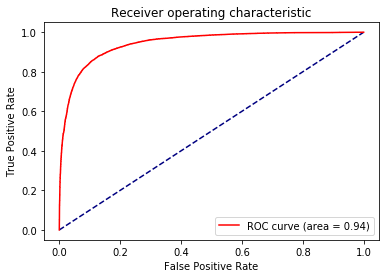

In [0]:
# Result
printResult(y_pred_bert_words_svm, y_prob_bert_words_svm)

> BERT Sentence Version Features

In [0]:
# Training 
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_svm = model.predict(bert_sentence_test_features)
y_prob_bert_sentences_svm = model.decision_function(bert_sentence_test_features)

Accuracy: 90.35

Confusion Matrix:
 [[11340  1160]
 [ 1253 11247]]
              precision    recall  f1-score   support

          -1       0.90      0.91      0.90     12500
           1       0.91      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Area under the ROC curve : 0.963879


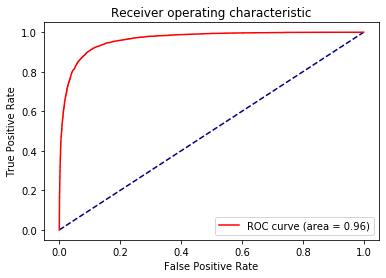

In [0]:
# Result
printResult(y_pred_bert_sentences_svm, y_prob_bert_sentences_svm)

# Naive Bayes

> Using the multinomial distribution of the Naive Bayes classifier leads to better results than the Gaussian distribution. But since Word2Vec and BERT embeddings may contain negative values, we use the Gaussian distribution for these two embeddings.

In [0]:
model = MultinomialNB()

> BOW Features

In [0]:
model = MultinomialNB()
# Training
model.fit(bow_training_features.toarray(), train_data["sentiment"])

# Evaluation
y_pred_bow_nb = model.predict(bow_test_features.toarray())

y_prob_bow_nb = model.predict_proba(bow_test_features.toarray())[:,1]

Accuracy: 81.30

Confusion Matrix:
 [[10889  1611]
 [ 3064  9436]]
              precision    recall  f1-score   support

          -1       0.78      0.87      0.82     12500
           1       0.85      0.75      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000

Area under the ROC curve : 0.889979


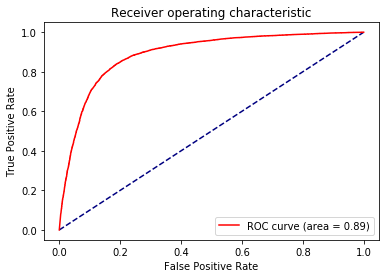

In [0]:
# Result
printResult(y_pred_bow_nb, y_prob_bow_nb)

> TFIDF with Stop Words Features

In [0]:
model = MultinomialNB()
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_nb = model.predict(tfidf_with_stop_test_features)

y_prob_tfidf_with_stop_nb = model.predict_proba(tfidf_with_stop_test_features)[:,1]

Accuracy: 86.31

Confusion Matrix:
 [[10882  1618]
 [ 1804 10696]]
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Area under the ROC curve : 0.938341


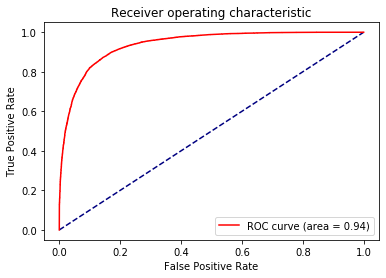

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_nb, y_prob_tfidf_with_stop_nb)

> TFIDF without Stop Words Features

In [0]:
model = MultinomialNB()
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_nb = model.predict(tfidf_no_stop_test_features)

y_prob_tfidf_no_stop_nb = model.predict_proba(tfidf_no_stop_test_features)[:,1]

Accuracy: 84.58

Confusion Matrix:
 [[10781  1719]
 [ 2136 10364]]
              precision    recall  f1-score   support

          -1       0.83      0.86      0.85     12500
           1       0.86      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.925618


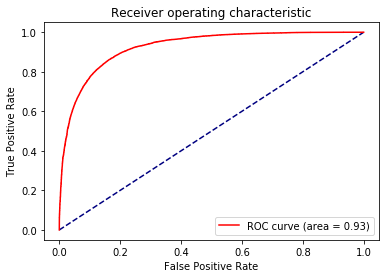

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_nb, y_prob_tfidf_no_stop_nb)

> Word2Vec with Stop Words Features

In [0]:
model = GaussianNB()
# Training 
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_nb = model.predict(word2vec_with_stop_test_features)

y_prob_w2v_with_stop_nb = model.predict_proba(word2vec_with_stop_test_features)[:,1]

Accuracy: 67.32

Confusion Matrix:
 [[9104 3396]
 [4773 7727]]
              precision    recall  f1-score   support

          -1       0.66      0.73      0.69     12500
           1       0.69      0.62      0.65     12500

    accuracy                           0.67     25000
   macro avg       0.68      0.67      0.67     25000
weighted avg       0.68      0.67      0.67     25000

Area under the ROC curve : 0.740370


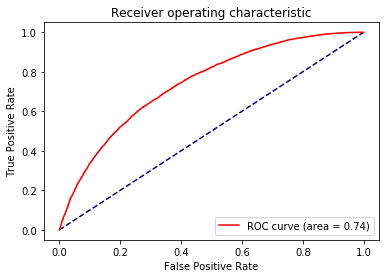

In [0]:
# Result
printResult(y_pred_w2v_with_stop_nb, y_prob_w2v_with_stop_nb)

> Word2Vec without Stop Words Features

In [0]:
model = GaussianNB()
# Training 
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_nb = model.predict(word2vec_no_stop_test_features)

y_prob_w2v_no_stop_nb = model.predict_proba(word2vec_no_stop_test_features)[:,1]

Accuracy: 74.74

Confusion Matrix:
 [[9481 3019]
 [3295 9205]]
              precision    recall  f1-score   support

          -1       0.74      0.76      0.75     12500
           1       0.75      0.74      0.74     12500

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000

Area under the ROC curve : 0.825627


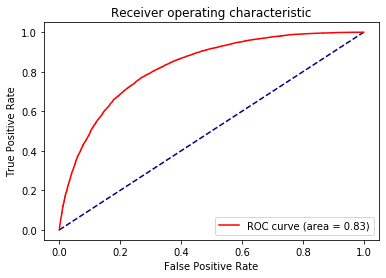

In [0]:
# Result
printResult(y_pred_w2v_no_stop_nb, y_prob_w2v_no_stop_nb)

> BERT Word Version Features

In [0]:
model = GaussianNB()

# Training 
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_nb = model.predict(bert_word_test_features)

y_prob_bert_words_nb = model.predict_proba(bert_word_test_features)[:,1]

Accuracy: 76.02

Confusion Matrix:
 [[10030  2470]
 [ 3525  8975]]
              precision    recall  f1-score   support

          -1       0.74      0.80      0.77     12500
           1       0.78      0.72      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000

Area under the ROC curve : 0.837514


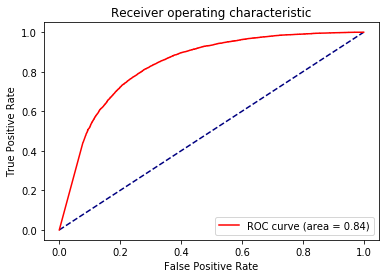

In [0]:
# Result
printResult(y_pred_bert_words_nb, y_prob_bert_words_nb)

> BERT Sentence Version Features

In [0]:
model = GaussianNB()

# Training 
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_nb = model.predict(bert_sentence_test_features)

y_prob_bert_sentences_nb = model.predict_proba(bert_sentence_test_features)[:,1]

Accuracy: 84.22

Confusion Matrix:
 [[10811  1689]
 [ 2257 10243]]
              precision    recall  f1-score   support

          -1       0.83      0.86      0.85     12500
           1       0.86      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.903838


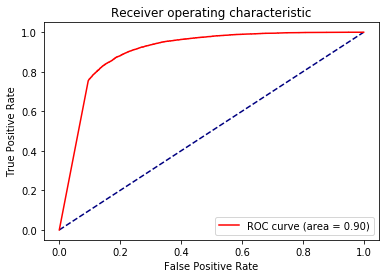

In [0]:
# Result
printResult(y_pred_bert_sentences_nb, y_prob_bert_sentences_nb)

# Decision tree

In [0]:
model = DecisionTreeClassifier()

> BOW Features

In [0]:
# Training
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_dt = model.predict(bow_test_features)

y_prob_bow_dt = model.predict_proba(bow_test_features)[:,1]

Accuracy: 72.54

Confusion Matrix:
 [[9110 3390]
 [3476 9024]]
              precision    recall  f1-score   support

          -1       0.72      0.73      0.73     12500
           1       0.73      0.72      0.72     12500

    accuracy                           0.73     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.73      0.73      0.73     25000

Area under the ROC curve : 0.725360


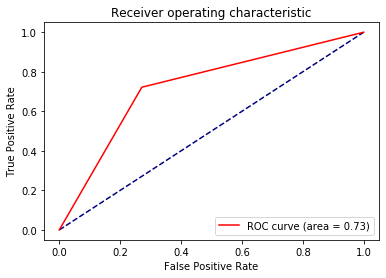

In [0]:
# Result
printResult(y_pred_bow_dt, y_prob_bow_dt)

> TFIDF with Stop Words Features

In [0]:
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_dt = model.predict(tfidf_with_stop_test_features)

y_prob_tfidf_with_stop_dt = model.predict_proba(tfidf_with_stop_test_features)[:,1]

Accuracy: 70.54

Confusion Matrix:
 [[8785 3715]
 [3649 8851]]
              precision    recall  f1-score   support

          -1       0.71      0.70      0.70     12500
           1       0.70      0.71      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000

Area under the ROC curve : 0.705440


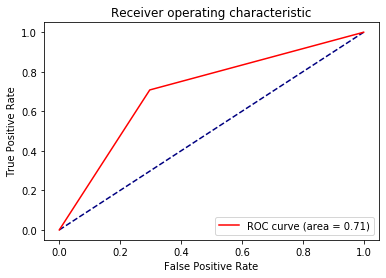

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_dt, y_prob_tfidf_with_stop_dt)

> TFIDF without Stop Words Features

In [0]:
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_dt = model.predict(tfidf_no_stop_test_features)

y_prob_tfidf_no_stop_dt = model.predict_proba(tfidf_no_stop_test_features)[:,1]

Accuracy: 71.15

Confusion Matrix:
 [[8958 3542]
 [3670 8830]]
              precision    recall  f1-score   support

          -1       0.71      0.72      0.71     12500
           1       0.71      0.71      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000

Area under the ROC curve : 0.711520


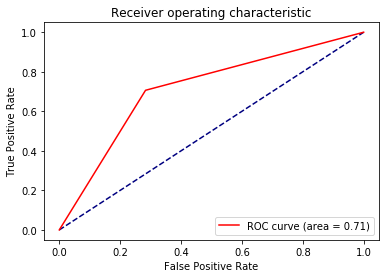

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_dt, y_prob_tfidf_no_stop_dt)

> Word2Vec with Stop Words Features

In [0]:
# Training
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_dt = model.predict(word2vec_with_stop_test_features)

y_prob_w2v_with_stop_dt = model.predict_proba(word2vec_with_stop_test_features)[:,1]

Accuracy: 67.42

Confusion Matrix:
 [[8494 4006]
 [4140 8360]]
              precision    recall  f1-score   support

          -1       0.67      0.68      0.68     12500
           1       0.68      0.67      0.67     12500

    accuracy                           0.67     25000
   macro avg       0.67      0.67      0.67     25000
weighted avg       0.67      0.67      0.67     25000

Area under the ROC curve : 0.674160


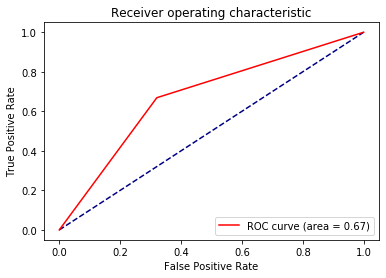

In [0]:
# Result
printResult(y_pred_w2v_with_stop_dt, y_prob_w2v_with_stop_dt)

> Word2Vec without Stop Words Features

In [0]:
# Training
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_dt = model.predict(word2vec_no_stop_test_features)

y_prob_w2v_no_stop_dt = model.predict_proba(word2vec_no_stop_test_features)[:,1]

Accuracy: 71.77

Confusion Matrix:
 [[9046 3454]
 [3603 8897]]
              precision    recall  f1-score   support

          -1       0.72      0.72      0.72     12500
           1       0.72      0.71      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000

Area under the ROC curve : 0.717720


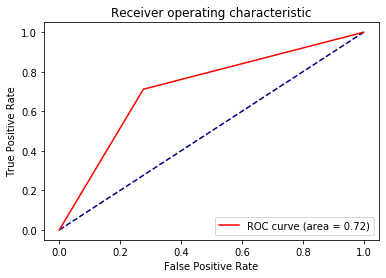

In [0]:
# Result
printResult(y_pred_w2v_no_stop_dt, y_prob_w2v_no_stop_dt)

> BERT Word Version Features

In [0]:
# Training
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_dt = model.predict(bert_word_test_features)

y_prob_bert_words_dt = model.predict_proba(bert_word_test_features)[:,1]

Accuracy: 69.63

Confusion Matrix:
 [[8807 3693]
 [3899 8601]]
              precision    recall  f1-score   support

          -1       0.69      0.70      0.70     12500
           1       0.70      0.69      0.69     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000

Area under the ROC curve : 0.696320


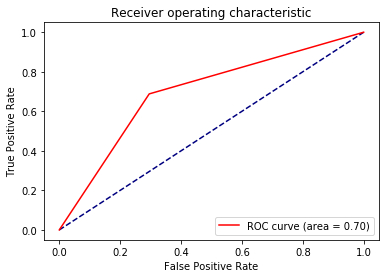

In [0]:
# Result
printResult(y_pred_bert_words_dt, y_prob_bert_words_dt)

> BERT Sentence Version Features

In [0]:
# Training
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_dt = model.predict(bert_sentence_test_features)

y_prob_bert_sentences_dt = model.predict_proba(bert_sentence_test_features)[:,1]

Accuracy: 77.97

Confusion Matrix:
 [[9700 2800]
 [2708 9792]]
              precision    recall  f1-score   support

          -1       0.78      0.78      0.78     12500
           1       0.78      0.78      0.78     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

Area under the ROC curve : 0.779680


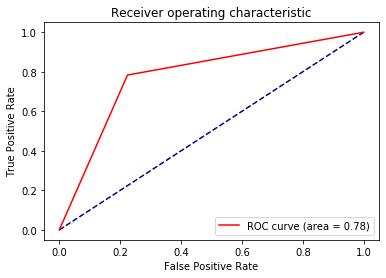

In [0]:
# Result
printResult(y_pred_bert_sentences_dt, y_prob_bert_sentences_dt)

# Random Forest

In [0]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

> BOW Features

In [0]:
# Training
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_rf = model.predict(bow_test_features)

y_prob_bow_rf = model.predict_proba(bow_test_features)[:,1]

Accuracy: 84.66

Confusion Matrix:
 [[10690  1810]
 [ 2024 10476]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.924084


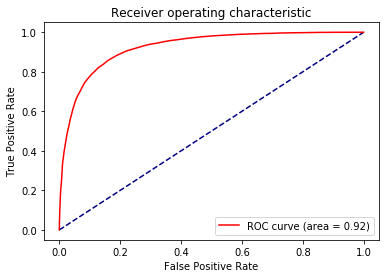

In [0]:
# Result
printResult(y_pred_bow_rf, y_prob_bow_rf)

> TFIDF with Stop Words Features

In [0]:
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_rf = model.predict(tfidf_with_stop_test_features)

y_prob_tfidf_with_stop_rf = model.predict_proba(tfidf_with_stop_test_features)[:,1]

Accuracy: 84.76

Confusion Matrix:
 [[10769  1731]
 [ 2080 10420]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.86      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.926842


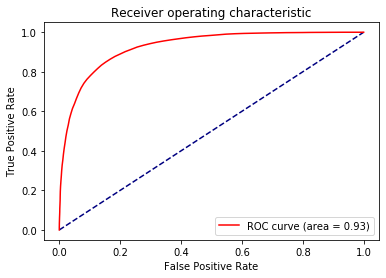

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_rf, y_prob_tfidf_with_stop_rf)

> TFIDF without Stop Words Features

In [0]:
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_rf = model.predict(tfidf_no_stop_test_features)

y_prob_tfidf_no_stop_rf = model.predict_proba(tfidf_no_stop_test_features)[:,1]

Accuracy: 85.15

Confusion Matrix:
 [[10780  1720]
 [ 1993 10507]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.926809


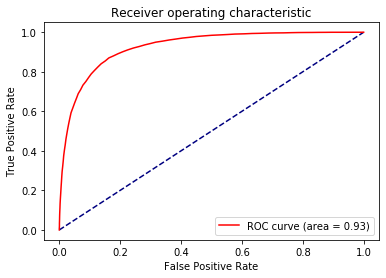

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_rf, y_prob_tfidf_no_stop_rf)

> Word2Vec with Stop Words Features

In [0]:
# Training
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_rf = model.predict(word2vec_with_stop_test_features)

y_prob_w2v_with_stop_rf = model.predict_proba(word2vec_with_stop_test_features)[:,1]

Accuracy: 79.59

Confusion Matrix:
 [[9980 2520]
 [2583 9917]]
              precision    recall  f1-score   support

          -1       0.79      0.80      0.80     12500
           1       0.80      0.79      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000

Area under the ROC curve : 0.873652


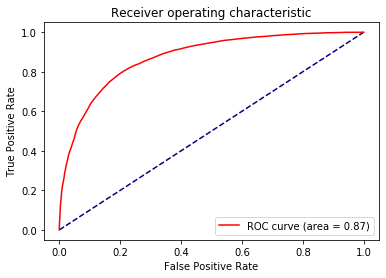

In [0]:
# Result
printResult(y_pred_w2v_with_stop_rf, y_prob_w2v_with_stop_rf)

> Word2Vec without Stop Words Features

In [0]:
# Training
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_rf = model.predict(word2vec_no_stop_test_features)

y_prob_w2v_no_stop_rf = model.predict_proba(word2vec_no_stop_test_features)[:,1]

Accuracy: 81.68

Confusion Matrix:
 [[10196  2304]
 [ 2277 10223]]
              precision    recall  f1-score   support

          -1       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.898837


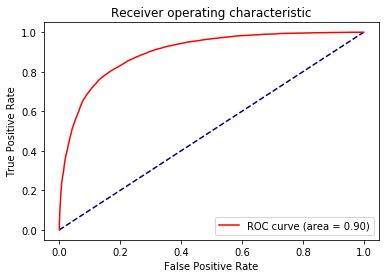

In [0]:
# Result
printResult(y_pred_w2v_no_stop_rf, y_prob_w2v_no_stop_rf)

> BERT Word Version Features

In [0]:
# Training
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_rf = model.predict(bert_word_test_features)

y_prob_bert_words_rf = model.predict_proba(bert_word_test_features)[:,1]

Accuracy: 82.35

Confusion Matrix:
 [[10337  2163]
 [ 2250 10250]]
              precision    recall  f1-score   support

          -1       0.82      0.83      0.82     12500
           1       0.83      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.902098


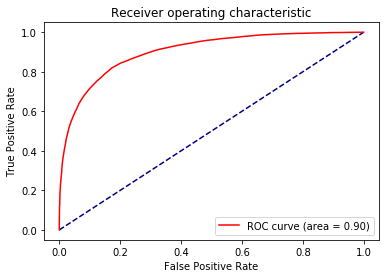

In [0]:
# Result
printResult(y_pred_bert_words_rf, y_prob_bert_words_rf)

> BERT Sentence Version Features

In [0]:
# Training
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_rf = model.predict(bert_sentence_test_features)

y_prob_bert_sentences_rf = model.predict_proba(bert_sentence_test_features)[:,1]

Accuracy: 86.26

Confusion Matrix:
 [[10768  1732]
 [ 1702 10798]]
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Area under the ROC curve : 0.937719


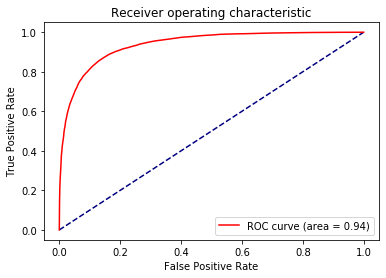

In [0]:
# Result
printResult(y_pred_bert_sentences_rf, y_prob_bert_sentences_rf)

# MLP

In [0]:
model = MLPClassifier(solver='adam', alpha=2e-4, hidden_layer_sizes=(5, 2), max_iter=400)

In [0]:
# Training
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_mlp = model.predict(bert_sentence_test_features)
y_prob_bert_sentences_mlp = model.predict_proba(bert_sentence_test_features)[:,1]

Accuracy: 90.32

Confusion Matrix:
 [[11228  1272]
 [ 1148 11352]]
              precision    recall  f1-score   support

          -1       0.91      0.90      0.90     12500
           1       0.90      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Area under the ROC curve : 0.961624


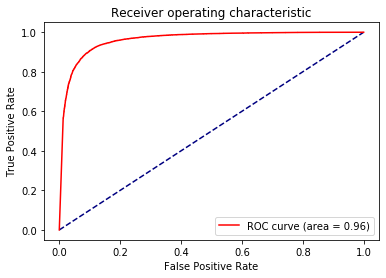

In [0]:
# Result
printResult(y_pred_bert_sentences_mlp, y_prob_bert_sentences_mlp)

# Deep Approaches:

# 1-D CNN + Mean Bert Features of each Review

In [0]:
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
model = Sequential()

model.add(layers.Conv1D(32, 10, activation='relu', input_shape=(768,1)))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 10, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 759, 32)           352       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 151, 32)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 142, 32)           10272     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 10,657
Trainable params: 10,657
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(bert_sentence_training_features.reshape(25000,768,1), train_data["sentiment"].values,
                    epochs=10,
                    batch_size=64,
                    validation_data=(bert_sentence_test_features.reshape(25000,768,1), test_data["sentiment"].values))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 9s 371us/step - loss: 0.5486 - acc: 0.7621 - val_loss: 0.4013 - val_acc: 0.8357
Epoch 2/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.4075 - acc: 0.8436 - val_loss: 0.3978 - val_acc: 0.8442
Epoch 3/10
25000/25000 [==============================] - 2s 91us/step - loss: 0.4113 - acc: 0.8468 - val_loss: 0.4007 - val_acc: 0.8458
Epoch 4/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.4084 - acc: 0.8503 - val_loss: 0.4144 - val_acc: 0.8455
Epoch 5/10
25000/25000 [==============================] - 2s 91us/step - loss: 0.4050 - acc: 0.8523 - val_loss: 0.4041 - val_acc: 0.8496
Epoch 6/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.4035 - acc: 0.8533 - val_loss: 0.3920 - val_acc: 0.8547
Epoch 7/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.4069 - acc: 0.8545 - val_loss: 0.4070 - val_ac

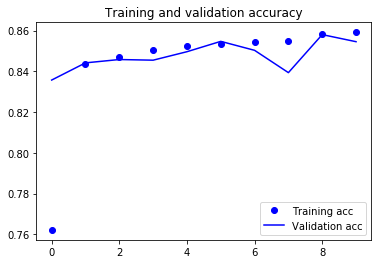

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Bert Features Word Version + LSTM

In [0]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dense , Bidirectional, LSTM , Embedding, Dropout , Activation, MaxPooling1D, Input
# from keras.layers import Bidirectional, GlobalMaxPool1D
# from keras.models import Model, Sequential
# from keras import optimizers, layers

In [0]:
# word_ids = tf.keras.Input(batch_shape=(None, None), dtype='int32')
# wordEmbeddings = BertEmbedding(model='bert_24_1024_16', dataset_name='book_corpus_wiki_en_cased')(word_ids)


# biLstm_output = Bidirectional(LSTM(32, return_sequences = True))(wordEmbeddings)
# avgPool_output = tf.keras.layers.GlobalAveragePooling1D()(biLstm_output)
# dense = tf.keras.layers.Dense(20, activation='relu')(avgPool_output)
# dropout_output = Dropout(rate=0.5)(dense)
# pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
# model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




# model = tf.keras.models.Model(inputs=word_ids, outputs=pred)


# opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.summary()


# BERT TensorFlow-HUB + Bi-Directional LSTM

In [9]:
!pip3 install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout,LSTM,Bidirectional,MaxPooling1D,Input,Embedding

In [0]:
sess = tf.Session()

In [0]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 256

In [0]:
test, validation = train_test_split(test_data, test_size=0.4)

In [0]:
train_text = train_data['clean_text_bert'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_data['sentiment'].tolist()

valid_text = validation['clean_text_bert'].tolist()
valid_text = [' '.join(t.split()[0:max_seq_length]) for t in valid_text]
valid_text = np.array(valid_text, dtype=object)[:, np.newaxis]
valid_label = validation['sentiment'].tolist()

test_text = test['clean_text_bert'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test['sentiment'].tolist()

In [0]:
class PaddingInputExample(object):
  """ToDo"""

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
  
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():

    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [0]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=256):

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples    

In [17]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
valid_examples = convert_text_to_examples(valid_text, valid_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)

(valid_input_ids, valid_input_masks, valid_segment_ids, valid_labels
) = convert_examples_to_features(tokenizer, valid_examples, max_seq_length=max_seq_length)    

(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=3,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)


    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        
        # Use "pooled_output" for classification tasks on an entire sentence.
        # Use "sequence_output" for token-level output.
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)
        return result['sequence_output']

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
# Build model
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    wordEmbeddings = BertLayer(n_fine_tune_layers=3, pooling="mean")(bert_inputs)

    biLstm_output = Bidirectional(LSTM(units=32, return_sequences=True,))(wordEmbeddings)

    avgPool_output = tf.keras.layers.GlobalAveragePooling1D()(biLstm_output)
    dense = tf.keras.layers.Dense(20, activation='relu')(avgPool_output)
    dropout_output = Dropout(rate=0.5)(dense)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)


    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [20]:
model = build_model(max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [0]:
# Instantiate variables
initialize_vars(sess)

In [0]:
# BiDirectional LSTM
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([valid_input_ids, valid_input_masks, valid_segment_ids], valid_labels),
    epochs=2,
    batch_size=32
)

Train on 25000 samples, validate on 10000 samples
Epoch 1/2
25000/25000 [==============================] - 1379s 55ms/sample - loss: 0.3037 - acc: 0.8742 - val_loss: 0.2257 - val_acc: 0.9086
Epoch 2/2
25000/25000 [==============================] - 1347s 54ms/sample - loss: 0.2216 - acc: 0.9132 - val_loss: 0.2281 - val_acc: 0.9077


In [0]:
# evaluate
results = model.evaluate([test_input_ids, test_input_masks, test_segment_ids], 
                         test_labels,
                         verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

15000/15000 - 206s - loss: 0.2319 - acc: 0.9061
loss: 0.232
acc: 0.906


In [0]:
# Dense (without Bi-Drirectional LSTM layer)
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([valid_input_ids, valid_input_masks, valid_segment_ids], valid_labels),
    epochs=2,
    batch_size=32
)

Train on 25000 samples, validate on 10000 samples
Epoch 1/2
25000/25000 [==============================] - 457s 18ms/sample - loss: 0.3013 - acc: 0.8706 - val_loss: 0.2685 - val_acc: 0.8874
Epoch 2/2
25000/25000 [==============================] - 453s 18ms/sample - loss: 0.2152 - acc: 0.9152 - val_loss: 0.2159 - val_acc: 0.9128


In [0]:
# evaluate
results = model.evaluate([test_input_ids, test_input_masks, test_segment_ids], 
                         test_labels,
                         verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

15000/15000 - 146s - loss: 0.2116 - acc: 0.9134
loss: 0.212
acc: 0.913


# Ranking for Base Classifiers

 <table style="width:100%">
  <tr>
    <th>Rank</th>
    <th>Word Embedding</th>
    <th>Classifier</th>
    <th>Accuracy</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>1</td>
    <td>BERT Sentence Version (Mean Bert Features per Review)</td>
    <td>SVM</td>
    <td bgcolor="#cedc00">90.35</td>
    <td>0.90</td>
  </tr>
  <tr>
    <td>2</td>
    <td>BERT Sentence Version (Mean Bert Features per Review)</td>
    <td>MLP</td>
    <td>90.32</td>
    <td>0.90</td>
  </tr>
  <tr>
    <td>3</td>
    <td>TFIDF with Stop Words</td>
    <td>SVM</td>
    <td>89.59</td>
    <td>0.90</td>
  </tr>
</table> 

# Ranking for Deep Neural Networks

<table style="width:100%">
  <tr>
    <th>Rank</th>
    <th>Word Embedding</th>
    <th>Model</th>
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>1</td>
    <td>BERT TensorFlow-HUB</td>
    <td>Bi-Directional LSTM</td>
    <td bgcolor="#cedc00">91.34</td>
  </tr>
  <tr>
    <td>2</td>
    <td>BERT Sentence Version (Mean Bert Features per Review)</td>
    <td>1-D CNN</td>
    <td>85.46</td>
  </tr>
</table>